In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  

Text(0,0.5,'Magnitud')

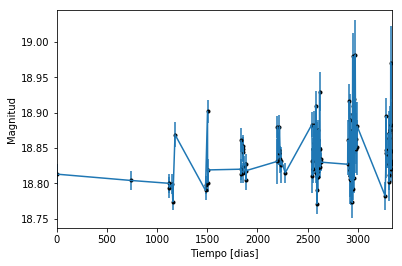

In [3]:
data = np.genfromtxt('LC_i_32769.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitud')

In [4]:
model = cm.CarmaModel(t, y, yerr, p=4, q=1)

In [5]:
%%capture capt
sample = model.run_mcmc(20000)

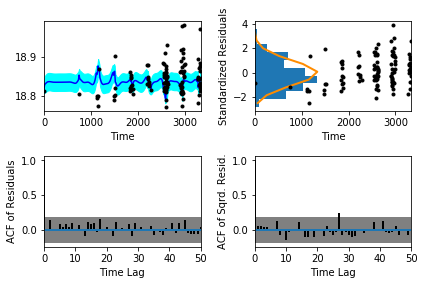

In [6]:
sample.assess_fit()

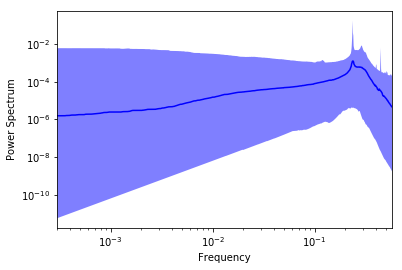

In [7]:
psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)

NameError: name 'noise_level' is not defined

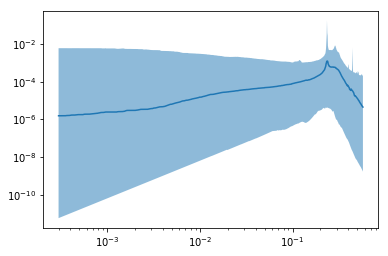

In [8]:
plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.ylim(noise_level / 10.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Espectro de potencia')
plt.xlabel('Frecuencia  [1 / dia]')
plt.annotate("Nivel de ruido", (1.25* plt.xlim()[0], noise_level / 1.5))

Text(0.5,1,'Prediccion , valor esperado ')

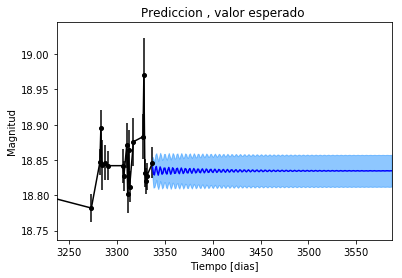

In [9]:
tpredict = t.max() + np.linspace(0.0, 250.0, 250)
ypredict, yp_var = sample.predict(tpredict)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tpredict, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tpredict, ypredict, 'b-')
plt.xlim(tpredict.min() - 100, tpredict.max())
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitud')
plt.title('Prediccion , valor esperado ')

Text(0.5,1,'Prediccion, Caminos simulados')

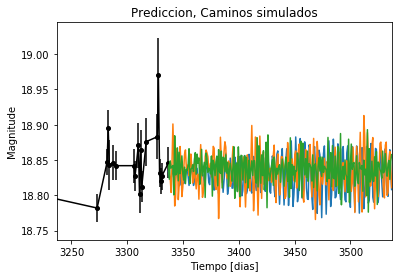

In [10]:
tpredict = t.max() + np.linspace(0.0, 200.0, 250)
npaths = 3
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
for i in range(npaths):
    ysim = sample.simulate(tpredict, bestfit='random')  # use a random draw of the CARMA parameters from its posterior
    plt.plot(tpredict, ysim)
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitude')
plt.xlim(tpredict.min()-100, tpredict.max())
plt.title('Prediccion, Caminos simulados')

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


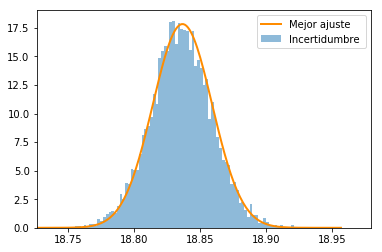

In [11]:
tpredict = 10.0
nsim = 10000
ysim = np.zeros(nsim)
for i in range(nsim):
    ysim[i] = sample.simulate(tpredict, bestfit='random')
yhat, yhvar = sample.predict(tpredict)
plt.hist(ysim, bins=100, alpha=0.5, histtype='stepfilled', normed=True, label='Incertidumbre ')
ymin, ymax = plt.xlim()
ygrid = np.linspace(ymin, ymax, 200)
predictive_pdf = 1.0 / np.sqrt(2.0 * np.pi * yhvar) * np.exp(-0.5 * (ygrid - yhat) ** 2 / yhvar)
plt.plot(ygrid, predictive_pdf, color='DarkOrange', lw=2, label='Mejor ajuste ')
plt.xlim(ymin, ymax + 0.1 * (ymax - ymin))
plt.legend(loc='upper right')

Text(0.5,1,'Interpolacion, camino simulado')

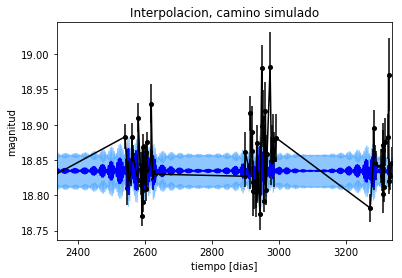

In [12]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
ypredict, yp_var = sample.predict(tinterp)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tinterp, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tinterp, ypredict, 'b-')
plt.xlabel('tiempo [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Text(0.5,1,'Interpolacion, camino simulado')

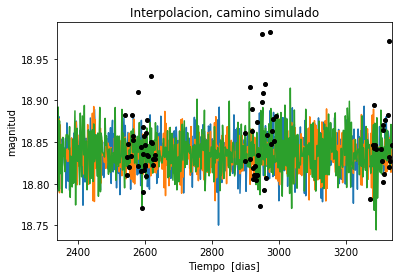

In [13]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
npaths = 3
for i in range(npaths):
    ysim = sample.simulate(tinterp, bestfit='random')
    plt.plot(tinterp, ysim)
plt.plot(t, y, 'ko', ms=4)
plt.xlabel('Tiempo  [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Plotting parameter summary


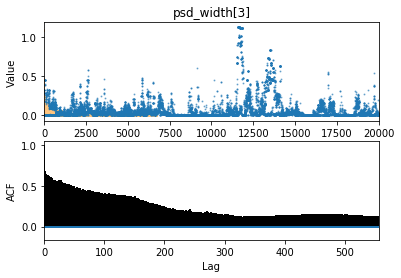

In [14]:
sample.plot_parameter('psd_width', 3, doShow=True)

In [15]:
centroid_samples = sample.get_samples('logpost')
centroid_samples.shape

(20000, 1)

In [16]:
sample.posterior_summaries('logpost')

Calculating effective number of samples
Posterior summary for parameter logpost  element 0
----------------------------------------------
Effective number of independent samples: 151.509519713
Median: 302.058626396
Standard deviation: 2.46993236673
68% credibility interval: [ 299.50492507  303.87048174]
95% credibility interval: [ 295.87140616  306.51382131]
99% credibility interval: [ 293.48139018  306.51382131]


In [17]:
centroid_samples = sample.get_samples('ar_coefs')
centroid_samples.shape

(20000, 5)

In [18]:
sample.posterior_summaries('ar_coefs')

Calculating effective number of samples
Posterior summary for parameter ar_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ar_coefs  element 1
----------------------------------------------
Effective number of independent samples: 120.514157414
Median: 1.30325251864
Standard deviation: 3.01511037112
68% credibility interval: [ 0.050325    5.25565862]
95% credibility interval: [  0.01192517  10.38235072]
99% credibility interval: [  1.14638589e-02   1.49543676e+01]
Posterior summary for parameter ar_coefs  element 2
----------------------------------------------
Effective number of independent samples: 534.668996265
Median: 9.95880480335
Standard deviation: 15.4698890502
68% credibility interval: [  4.92610931  28.98729762]
95% credibility interval: [  2

In [19]:
centroid_samples = sample.get_samples('ma_coefs')
centroid_samples.shape

(20000, 2)

In [20]:
sample.posterior_summaries('ma_coefs')

Calculating effective number of samples
Posterior summary for parameter ma_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ma_coefs  element 1
----------------------------------------------
Effective number of independent samples: 12567.1823509
Median: 6.39679101271e-30
Standard deviation: 2.02892965886e+39
68% credibility interval: [  1.14786399e-101   5.10180501e+011]
95% credibility interval: [  4.89859710e-161   2.34435365e+031]
99% credibility interval: [  3.27568481e-198   5.77255025e+038]


In [21]:
centroid_samples = sample.get_samples('mu')
centroid_samples.shape

(20000, 1)

In [22]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [23]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 666.446447094
Median: 0.367025760335
Standard deviation: 0.241628159021
68% credibility interval: [ 0.27191089  0.76606513]
95% credibility interval: [ 0.12588935  1.02865196]
99% credibility interval: [ 0.          1.12515642]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 666.446447094
Median: 0.367025760335
Standard deviation: 0.241628159021
68% credibility interval: [ 0.27191089  0.76606513]
95% credibility interval: [ 0.12588935  1.02865196]
99% credibility interval: [ 0.          1.12515642]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 291.456938133
Median: 0.233628796155
Standard deviation: 0.132180203052


In [24]:
centroid_samples = sample.get_samples('loglik')
centroid_samples.shape

(20000, 1)

In [25]:
sample.posterior_summaries('loglik')

Calculating effective number of samples
Posterior summary for parameter loglik  element 0
----------------------------------------------
Effective number of independent samples: 151.509519713
Median: 302.058626396
Standard deviation: 2.46993236673
68% credibility interval: [ 299.50492507  303.87048174]
95% credibility interval: [ 295.87140616  306.51382131]
99% credibility interval: [ 293.48139018  306.51382131]


In [26]:
centroid_samples = sample.get_samples('psd_width')
centroid_samples.shape

(20000, 4)

In [27]:
sample.posterior_summaries('psd_width')

Calculating effective number of samples
Posterior summary for parameter psd_width  element 0
----------------------------------------------
Effective number of independent samples: 251.121636812
Median: 0.0244695289559
Standard deviation: 0.145301624164
68% credibility interval: [ 0.00137225  0.14671925]
95% credibility interval: [  4.77620943e-04   5.60206071e-01]
99% credibility interval: [  3.63835040e-04   8.35686670e-01]
Posterior summary for parameter psd_width  element 1
----------------------------------------------
Effective number of independent samples: 218.604001186
Median: 0.0238506391005
Standard deviation: 0.13164416599
68% credibility interval: [ 0.00127027  0.13831115]
95% credibility interval: [ 0.00047762  0.47070057]
99% credibility interval: [  3.63835040e-04   8.04784798e-01]
Posterior summary for parameter psd_width  element 2
----------------------------------------------
Effective number of independent samples: 136.164426651
Median: 0.0393011403832
Standard dev

In [28]:
centroid_samples = sample.get_samples('var')
centroid_samples.shape

(20000, 1)

In [29]:
sample.posterior_summaries('var')

Calculating effective number of samples
Posterior summary for parameter var  element 0
----------------------------------------------
Effective number of independent samples: 305.451141352
Median: 0.000554608796996
Standard deviation: 0.000221594242535
68% credibility interval: [ 0.00035626  0.00080148]
95% credibility interval: [ 0.00019669  0.00103327]
99% credibility interval: [ 0.00013397  0.00129178]


In [30]:
centroid_samples = sample.get_samples('measerr_scale')
centroid_samples.shape

(20000, 1)

In [31]:
sample.posterior_summaries('measerr_scale')

Calculating effective number of samples
Posterior summary for parameter measerr_scale  element 0
----------------------------------------------
Effective number of independent samples: 196.01772115
Median: 1.45884777812
Standard deviation: 0.293819705469
68% credibility interval: [ 1.14449617  1.79080434]
95% credibility interval: [ 0.93337919  1.96956306]
99% credibility interval: [ 0.82530138  1.99841477]


In [32]:
centroid_samples = sample.get_samples('sigma')
centroid_samples.shape

(20000, 1)

In [33]:
sample.posterior_summaries('sigma')

Calculating effective number of samples
Posterior summary for parameter sigma  element 0
----------------------------------------------
Effective number of independent samples: 187.766214652
Median: 0.00887914025477
Standard deviation: 1.16198555422
68% credibility interval: [  3.60191918e-13   4.52846396e-01]
95% credibility interval: [  4.07315827e-33   2.14905034e+00]
99% credibility interval: [  1.49545981e-40   1.02123073e+01]


In [34]:
centroid_samples = sample.get_samples('ar_roots')
centroid_samples.shape

(20000, 4)

In [35]:
sample.posterior_summaries('ar_roots')

Calculating effective number of samples
Posterior summary for parameter ar_roots  element 0
----------------------------------------------
Effective number of independent samples: 251.121636812
Median: (-0.153746584809-2.25103707795j)
Standard deviation: 1.77155442315
68% credibility interval: [-0.92186425-3.10813926j -0.00862209-4.79040956j]
95% credibility interval: [ -3.51987855e+00-3.50523334j  -3.00098089e-03-3.07866751j]
99% credibility interval: [ -5.25077420e+00-4.03099125j  -2.28604298e-03-2.27873952j]
Posterior summary for parameter ar_roots  element 1
----------------------------------------------
Effective number of independent samples: 218.604001186
Median: (-0.149857985163+1.79131091416j)
Standard deviation: 1.72889643208
68% credibility interval: [-0.86903461+1.77185723j -0.00798134+4.82586184j]
95% credibility interval: [-2.95749893+3.21535345j -0.00300098+3.07866751j]
99% credibility interval: [ -5.05661202e+00+6.34994069j  -2.28604298e-03+2.27873952j]
Posterior summar

Plotting 2d PDF w KDE


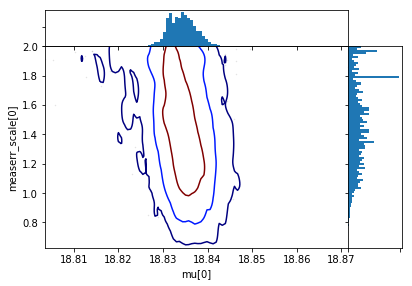

In [36]:
sample.plot_2dkde('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


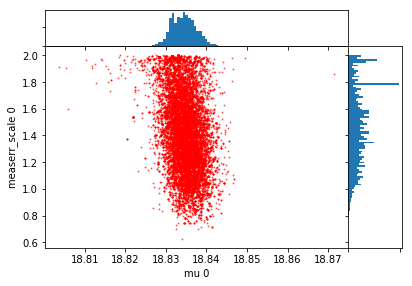

In [37]:
sample.plot_2dpdf('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


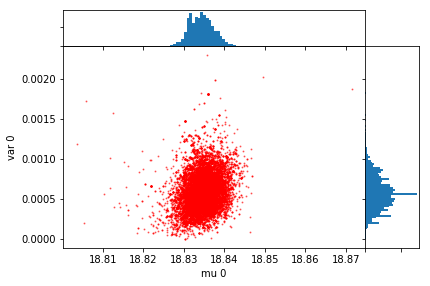

In [38]:
sample.plot_2dpdf('mu', 'var', doShow=True)

Plotting 2d PDF w KDE


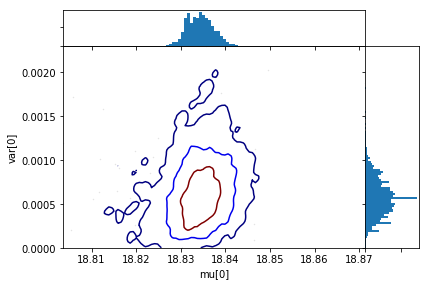

In [39]:
sample.plot_2dkde('mu', 'var', doShow=True)